In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta

import get_initial_values_for_model1 as get_init_model1
import get_initial_values_for_model2 as get_init_model2

from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('data/wholetime.csv')

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/2641153119.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/wholetime.csv')


In [3]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()

node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)

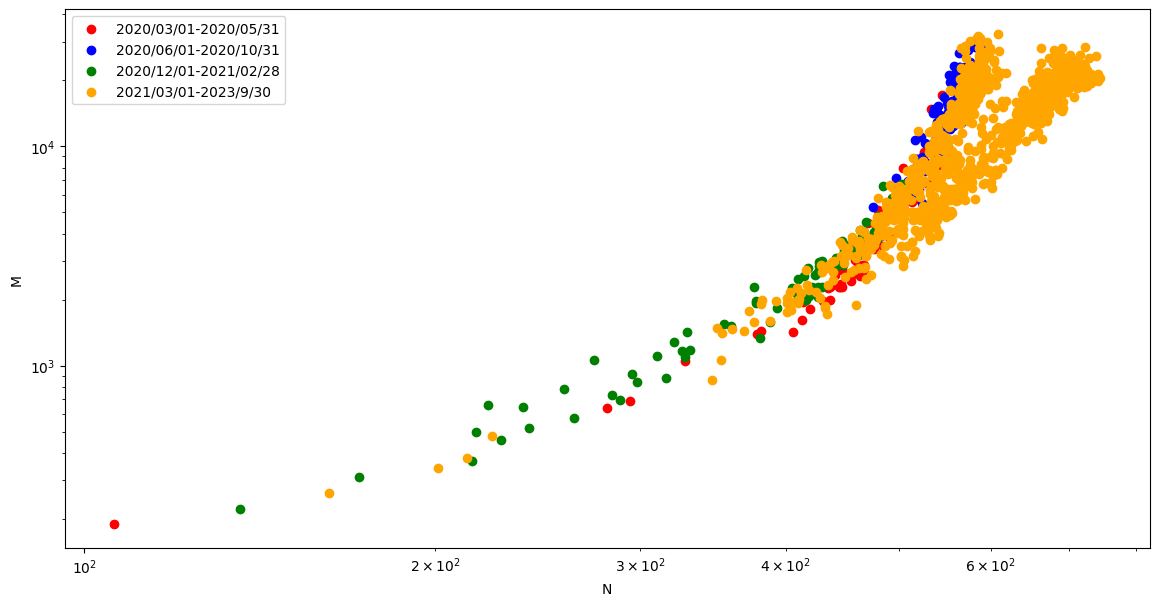

In [9]:
# color
color_list = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p1, edge_list_p1, label='2020/03/01-2020/05/31', color=color_list[0])
plt.scatter(node_list_p2, edge_list_p2, label='2020/06/01-2020/10/31', color=color_list[1])
plt.scatter(node_list_p3, edge_list_p3, label='2020/12/01-2021/02/28', color=color_list[2])
plt.scatter(node_list_p4, edge_list_p4, label='2021/03/01-2023/9/30', color=color_list[3])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [7]:
df_del = df[(df['started_at'] >= '2020-11-01') & (df['started_at'] < '2020-12-01')].dropna()
node_list_del, edge_list_del, timestamp_del = return_nm(df_del)

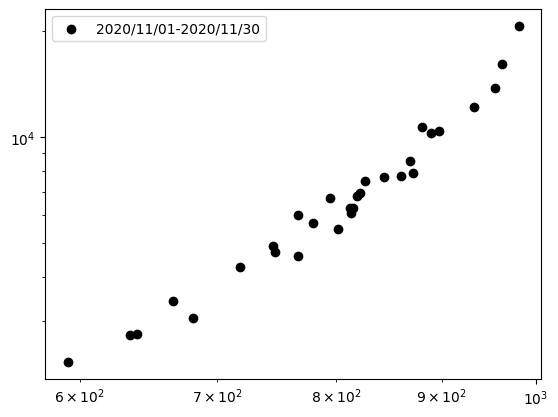

In [9]:
plt.scatter(node_list_del, edge_list_del, label='2020/11/01-2020/11/30', color='black')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [6]:
# df_p4を年単位で分割する
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-01-01')].dropna()
df_p4_3 = df[(df['started_at'] >= '2023-01-01') & (df['started_at'] < '2024-01-01')].dropna()

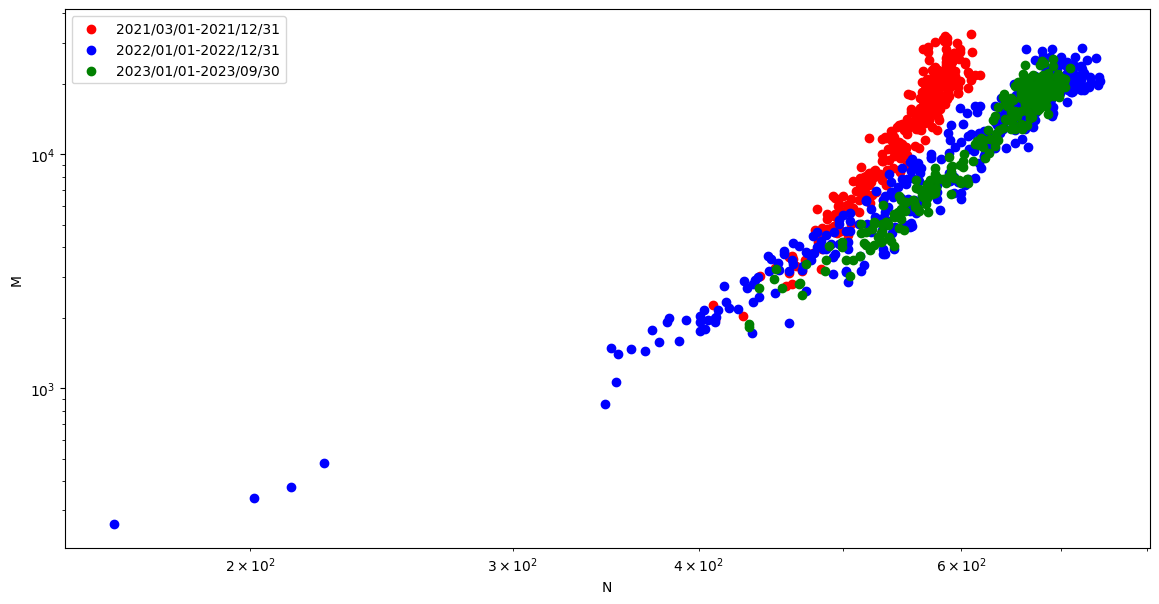

In [7]:
# plot
node_list_p4_1, edge_list_p4_1, timestamp_p4_1 = return_nm(df_p4_1)
node_list_p4_2, edge_list_p4_2, timestamp_p4_2 = return_nm(df_p4_2)
node_list_p4_3, edge_list_p4_3, timestamp_p4_3 = return_nm(df_p4_3)

plt.figure(figsize=(14, 7))
plt.scatter(node_list_p4_1, edge_list_p4_1, label='2021/03/01-2021/12/31', color=color_list[0])
plt.scatter(node_list_p4_2, edge_list_p4_2, label='2022/01/01-2022/12/31', color=color_list[1])
plt.scatter(node_list_p4_3, edge_list_p4_3, label='2023/01/01-2023/09/30', color=color_list[2])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [5]:
"""
Kobayashi & Génois (2021)のモデルを用いて、計算する
"""
def model1(m, m0, kappa):
    Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
    res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
    if res.any() < 0:
        return 0
    else:
        return res
    
def model2(m, m0, Np):
    kappa = 8*m0/(Np**2-Np)
    res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
    if res.any() < 0:
        return 0
    else:
        return res
    
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [6]:
# dfを2つに分解する
df_2020_2021 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2021-12-01')].dropna()
df_2022_2023 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()

# df_2020_2021から2020-11-01から2020-11-30のデータを削除する
df_2020_2021 = df_2020_2021[(df_2020_2021['started_at'] < '2020-11-01') | (df_2020_2021['started_at'] >= '2020-12-01')]

In [7]:
node_list_2020_2021, edge_list_2020_2021, timestamp_2020_2021 = return_nm(df_2020_2021)
node_list_2022_2023, edge_list_2022_2023, timestamp_2022_2023 = return_nm(df_2022_2023)

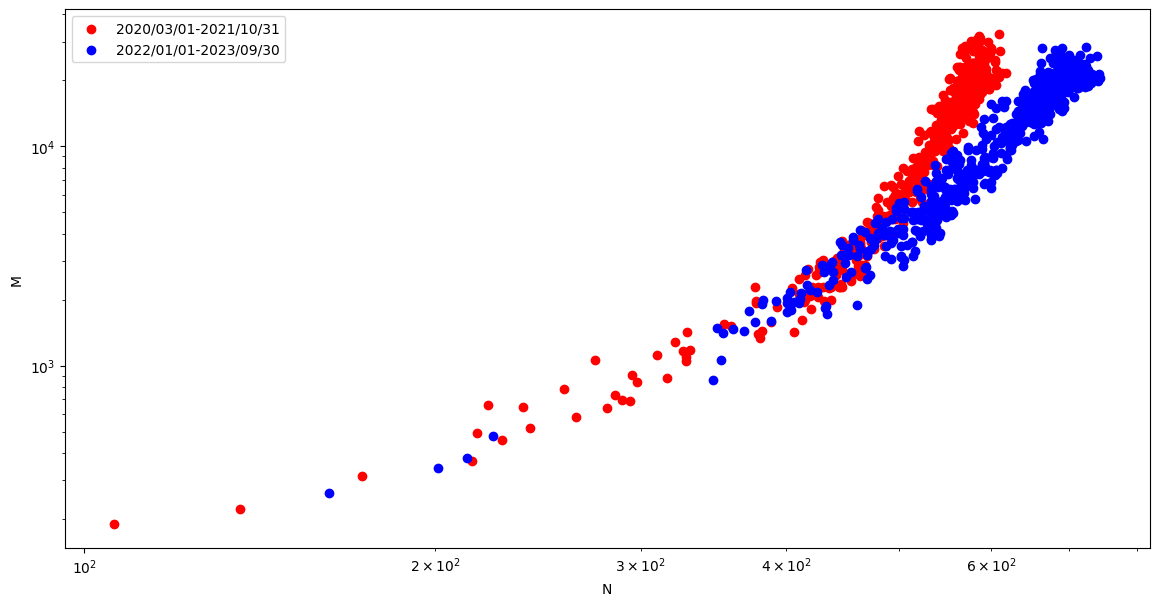

In [10]:
plt.figure(figsize=(14, 7))
plt.scatter(node_list_2020_2021, edge_list_2020_2021, label='2020/03/01-2021/10/31', color=color_list[0])
plt.scatter(node_list_2022_2023, edge_list_2022_2023, label='2022/01/01-2023/09/30', color=color_list[1])
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [85]:
init_m0_range = [1, 1000]
init_kappa_range = [0.005, 3]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(200):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_2020_2021, node_list_2020_2021, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_2020_2021 - model1(edge_list_2020_2021, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]

N_fit = []
M_fit = []
popt, pcov = curve_fit(model1, edge_list_2020_2021, node_list_2020_2021, p0=[m0_init, kappa_init])
kappa = popt[1]
Np = []
for i in range(len(edge_list_2020_2021)):
    Np.append((1 + np.sqrt(1 + ((32*edge_list_2020_2021[i]) / kappa))) / 2)

for i in range(len(node_list_2020_2021)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_2020_2021)):
    M_fit.append(calc_M(Np[i], kappa))


[3.60901338e+03 9.86472593e-02]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:6: RuntimeWarning: overflow encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )


In [92]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range2 = [1, 1000]
init_Np_range2 = [1, 1000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range2)
    init_Np = np.random.uniform(*init_Np_range2)
    

    popt, pcov = curve_fit(model2, edge_list_2020_2021, node_list_2020_2021, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_2020_2021 - model2(edge_list_2020_2021, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

N_fit2 = []
M_fit2 = []
popt, pcov = curve_fit(model2, edge_list_2020_2021, node_list_2020_2021, p0=[m0_init2, Np_init2])
Np2 = popt[1]
kappa2 = []
for i in range(len(edge_list_2020_2021)):
    kappa2.append((8*edge_list_2020_2021[i])/(Np2**2-Np2))

for i in range(len(node_list_2020_2021)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_2020_2021)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

[65522.84379717   522.26396785]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:14: RuntimeWarning: invalid value encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:14: RuntimeWarning: overflow encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


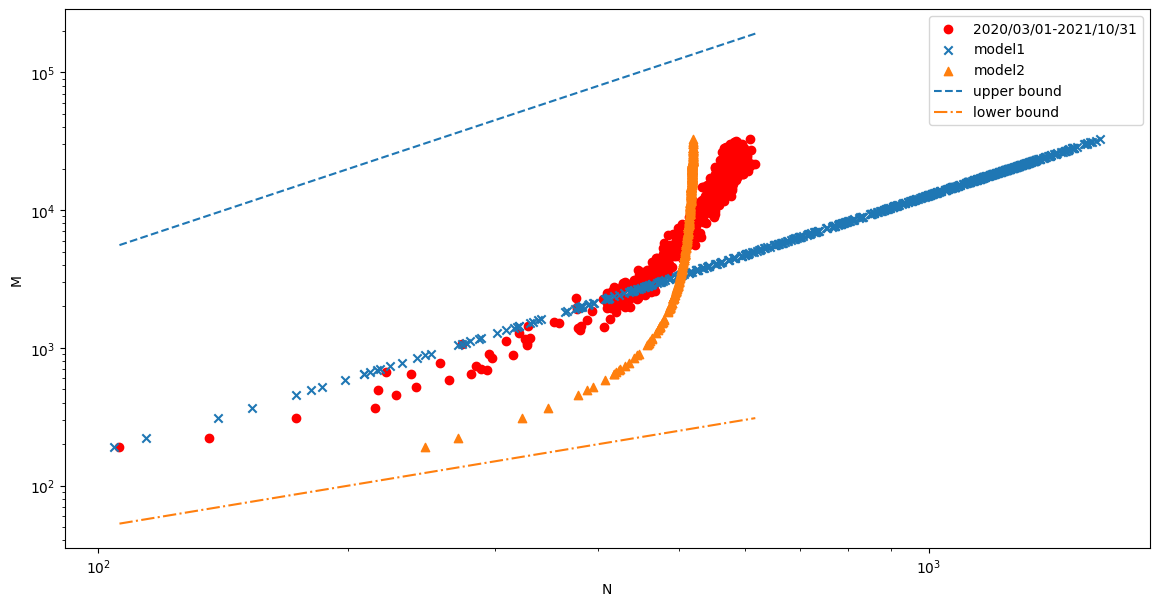

In [93]:
# プロット
nn = len(node_list_2020_2021)
xmin = min(node_list_2020_2021)
xmax = max(node_list_2020_2021)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(node_list_2020_2021, edge_list_2020_2021, label='2020/03/01-2021/10/31', color=color_list[0])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

## 2022~2023を分析

In [126]:
init_m0_range = [1, 1000]
init_kappa_range = [0.005, 3]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(200):
    init_m0 = np.random.uniform(*init_m0_range)
    init_kappa = np.random.uniform(*init_kappa_range)
    

    popt, pcov = curve_fit(model1, edge_list_2022_2023, node_list_2022_2023, p0=[init_m0, init_kappa])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_2022_2023 - model1(edge_list_2022_2023, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit = popt

print(best_fit)  # 最良のフィットパラメータを表示
m0_init = best_fit[0]
kappa_init = best_fit[1]


N_fit = []
M_fit = []
popt, pcov = curve_fit(model1,edge_list_2022_2023,node_list_2022_2023,p0=[m0_init, kappa_init])
print("model1: ", popt)

Np = []
kappa = popt[1]
for i in range(len(edge_list_2022_2023)):
    Np.append((1+np.sqrt(1+32*edge_list_2022_2023[i]/kappa))/2)


for i in range(len(node_list_2022_2023)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_2022_2023)):
    M_fit.append(calc_M(Np[i], kappa))

[4.60990611e+03 9.47141976e-02]
model1:  [4.60990611e+03 9.47141976e-02]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:6: RuntimeWarning: invalid value encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:5: RuntimeWarning: invalid value encountered in sqrt
  Np = (1 + np.sqrt(1 + ((32*m0) / kappa))) / 2
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:6: RuntimeWarning: overflow encountered in scalar power
  res = Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) )


In [127]:
# 初期値を探す for model2
# 初期値の範囲を設定
init_m0_range2 = [1, 1000]
init_Np_range2 = [1, 1000]


best_fit = None
best_error = np.inf

# ランダムな初期値で最適化を複数回実行
for _ in range(100):
    init_m0 = np.random.uniform(*init_m0_range2)
    init_Np = np.random.uniform(*init_Np_range2)
    

    popt, pcov = curve_fit(model2, edge_list_2022_2023, node_list_2022_2023, p0=[init_m0, init_Np])

    # フィットの良さ（二乗誤差）を計算
    residuals = node_list_2022_2023 - model2(edge_list_2022_2023, *popt)
    error = np.sum(residuals**2)

    # 最良のフィットを更新
    if error < best_error:
        best_error = error
        best_fit2 = popt

print(best_fit2)  # 最良のフィットパラメータを表示
m0_init2 = best_fit2[0]
Np_init2 = best_fit2[1]

N_fit2 = []
M_fit2 = []
popt, pcov = curve_fit(model2, edge_list_2022_2023, node_list_2022_2023, p0=[m0_init2, Np_init2])
Np2 = popt[1]
kappa2 = []
for i in range(len(edge_list_2022_2023)):
    kappa2.append((8*edge_list_2022_2023[i])/(Np2**2-Np2))

for i in range(len(node_list_2022_2023)):
    N_fit2.append(calc_N(Np2, kappa2[i]))

for i in range(len(edge_list_2022_2023)):
    M_fit2.append(calc_M(Np2, kappa2[i]))

[13051.37816337   610.51016005]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:14: RuntimeWarning: invalid value encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_3670/4113075532.py:14: RuntimeWarning: overflow encountered in scalar power
  res = Np*(1-2/(kappa*Np)*(1-(1-(kappa/2))**Np))


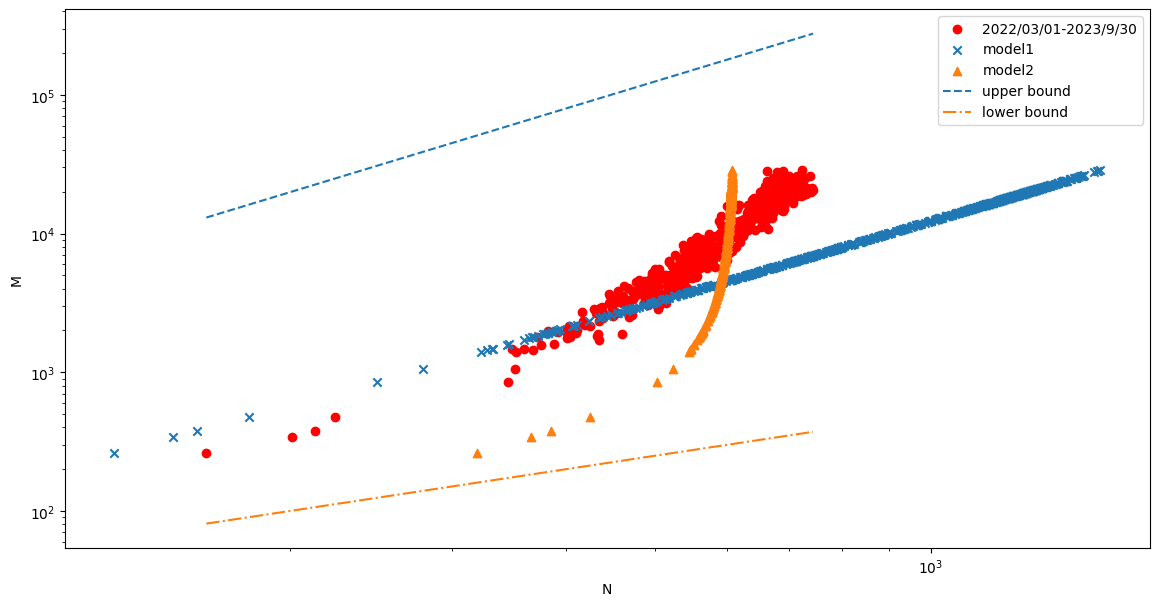

In [128]:
# プロット
nn = len(node_list_2022_2023)
xmin = min(node_list_2022_2023)
xmax = max(node_list_2022_2023)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2



plt.figure(figsize=(14, 7))
plt.scatter(node_list_2022_2023, edge_list_2022_2023, label='2022/03/01-2023/9/30', color=color_list[0])
plt.scatter(N_fit, M_fit, label='model1', marker='x')
plt.scatter(N_fit2, M_fit2, label='model2', marker='^')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()